<a href="https://colab.research.google.com/github/DeanIA/dl4m_final/blob/main/generate_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# import libraries
import os
import math
import requests
import shutil
from google.colab import drive
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.vgg16 import preprocess_input
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# Querying Satellite Imagery from MapBox API

## Set Mapbox API token

To run these queries, you must first create an API Key here: [MapBox API FAQs](https://). Replace 'YOUR_API_KEY' with your API key in the quotes to set as a string to your os environment.

A free account is capped at 50k images/month and 1250/hr. Be careful not to exhaust this too quickly while running these scripts.

In [ ]:
os.environ['mapbox_api_key'] = 'YOUR_API_KEY'
mapbox_api_key = os.getenv('mapbox_api_key')

## Set Up Directories for Storage

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/dl4m_final_project/data/raw/mapbox/

/content/drive/MyDrive/dl4m_final_project/data/raw/mapbox


In [ ]:
# create folder to store images at this timestamp

# build a folder name like "images_20250421_193045"
now       = datetime.now()
date_str  = now.strftime('%Y%m%d')
time_str  = now.strftime('%H%M%S')
folder_name = f'images_{date_str}_{time_str}'

# create folder to store images
os.makedirs(folder_name, exist_ok=True)

These are helper functions to generate an image at the latitude and longitude provided. The process is as follows:


*   converts latitude, longitude, and zoom into values that align with the mapbox api (x and y value)
*   queries mapbox using api request
*   returns a static image to the folder created above

Some of this adapted from this post: https://gis.stackexchange.com/questions/341330/get-zoomed-in-images-with-the-earthexplorer-api.


In [ ]:
# Get the y tile value based on a latitude value
def latToTile(latDeg, zoom):
    latRadians = math.radians(latDeg)
    n = 2.0 ** zoom
    return int((1.0 - math.asinh(math.tan(latRadians)) / math.pi) / 2.0 * n)

# Get the x tile value based on a longitude value
def lonToTile(lonDeg, zoom):
    n = 2.0 ** zoom
    return int((lonDeg + 180.0) / 360.0 * n)

# Download an image for a specified location into our new folder
def getImage(latitude, longitude, zoom, accessToken):
    url = (
        f"https://api.mapbox.com/v4/mapbox.satellite/"
        f"{zoom}/{lonToTile(longitude, zoom)}/{latToTile(latitude, zoom)}@2x.png"
        f"?access_token={accessToken}"
    )
    # point into folder_name generated above
    image_path = os.path.join(folder_name, f"{latitude},{longitude}.png")

    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(image_path, "wb") as img_file:
        shutil.copyfileobj(response.raw, img_file)
    response.close()
    return image_path

Test a single query on Chris' apartment building.

In [ ]:
# 40.6875593,-73.9478998

path = getImage(latitude=40.6875594,
                longitude=-73.9478998,
                zoom=16,
                accessToken=mapbox_api_key)

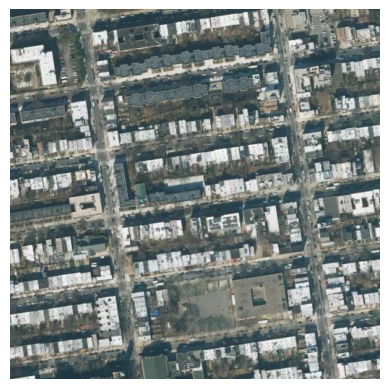

In [ ]:
# open the file you just saved
img = Image.open(path)  # path returned by getImage()

# show it with matplotlib
plt.imshow(img)
plt.axis('off')
plt.show()


# Pulling Census Data

Import census dataset. This is a dataset that was transformed in R to generate a geo_id, lat, lon, and pop_density for each census tract.

In [ ]:
df = pd.read_csv('../../parsed/tract_data.csv')

print(df.head())

   Unnamed: 0                geo_id    NAME        lon        lat  \
0           1  1400000US36093033102  331.02 -74.180507  42.779891   
1           2  1400000US36093020102  201.02 -73.916141  42.829537   
2           3  1400000US36093032504  325.04 -74.031123  42.910368   
3           4  1400000US36081003400   34.00 -73.858187  40.684773   
4           5  1400000US36081003900   39.00 -73.940932  40.762799   

    pop_density  pop_dens_log  density_label  
0     82.879449      4.429381            1.0  
1   6961.953574      8.848359            2.0  
2     87.483183      4.482813            1.0  
3  31469.229320     10.356797            3.0  
4  25975.551364     10.164950            3.0  


Utilizing the Mapbox API, generate an image for each lat/lon pairing.

In [ ]:
def generate_tract_images(df, access_token, zoom=17, folder_name=None, lat_col='lat', lon_col='lon', id_col='geo_id'):
    """
    Generate Mapbox satellite tile images for each row in df.

    Parameters:
      - df: pandas DataFrame with columns for latitude, longitude, and an identifier
      - access_token: Mapbox API access token
      - zoom: zoom level for tiles (default 17)
      - folder_name: optional; if None, a timestamped folder is created
      - lat_col, lon_col: names of the latitude and longitude columns in df
      - id_col: name of the column to use for image filenames

    Returns:
      - List of file paths for the saved images
    """
    # create a timestamped folder if none provided
    if folder_name is None:
        now = datetime.now()
        folder_name = f"images_{now.strftime('%Y%m%d')}_{now.strftime('%H%M%S')}"
    os.makedirs(folder_name, exist_ok=True)

    saved_paths = []
    base_url = "https://api.mapbox.com/v4/mapbox.satellite"

    for idx, row in df.iterrows():
        lat = row[lat_col]
        lon = row[lon_col]
        tile_x = lonToTile(lon, zoom)
        tile_y = latToTile(lat, zoom)
        url = f"{base_url}/{zoom}/{tile_x}/{tile_y}@2x.png?access_token={access_token}"

        image_filename = f"{row[id_col]}.png"
        image_path = os.path.join(folder_name, image_filename)

        try:
            response = requests.get(url, stream=True, timeout=30)
            response.raise_for_status()
            with open(image_path, "wb") as img_file:
                shutil.copyfileobj(response.raw, img_file)
            response.close()
            saved_paths.append(image_path)
        except Exception as e:
            print(f"Failed for {row[id_col]} ({lat}, {lon}): {e}")

    return saved_paths


Run the image generation function for each census tract.

In [ ]:
# run on the original dataset

paths = generate_tract_images(df, access_token=mapbox_api_key, zoom=16)
